In [41]:
# Daten einlesen

%matplotlib inline
import pymssql
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib

conn = pymssql.connect("pcs.f4.htw-berlin.de",
                       "Masterprojekt", "Masterprojekt", "PraediktiveAnalysenTest")
cursor = conn.cursor()

df = pd.read_sql('SELECT * FROM Maschinendaten_20181206', conn)
conn.close()

# unnötige Spalten entfernen
df.pop('Timestamp')
df.pop('Produktionsprogramm')
df.pop('SollMenge')
df.pop('IstMenge')
df.pop('Ausschuss')
df.pop('Machine_ID')
df.pop('Maschine')
df.pop('Datum')
df.pop('Uhrzeit')
df.pop('ID')

# umgekehrt sortieren
df = df.sort_index(ascending=False)

df.head()


,Drehzahl,Leistungsaufnahme,Vibration,Lautstaerke,Temperatur,FehlerID
8571,0.0,1.473,0.038,25.148,100.0,F001
8570,0.0,1.426,-0.009,25.083,100.0,F001
8569,0.0,1.472,0.079,25.090,100.0,F001
8568,0.0,1.500,-0.090,25.034,100.0,F001
8567,0.0,1.443,0.020,25.165,100.0,F001


In [42]:
# Kopie anlegen
df_f = df

# Datensätze filtern nach ... und in neuer Variable speichern df_f f=gefiltert
# ... ungeplanten Stillständen (Zufallsfehler)
df_f = df_f.query('FehlerID != "A000"')
df_f = df_f.query('FehlerID != "A001"')
df_f = df_f.query('FehlerID != "A002"')
df_f = df_f.query('FehlerID != "A003"')
df_f = df_f.query('FehlerID != "A004"')
# FehlerID durchsuchen und Zähler anlegen, der angibt wie lang es bis zu nächsten Ausfall dauert
x = []
y = 0
for row in df_f['FehlerID']:
    if row == "x000":
        y += 1
        x.append(y)
    else:
        y = 0
        x.append(y)
# "Ausfallentfernung" an df_s anhängen
df_f['NaechsterAusfall'] = x
        
# Nächste FehlerID durchsuchen, neue Spalte mit Nächster FehlerID (nF001) erzeugen
x = []
y = "NaN"
for row in df_f['FehlerID']:
    if row == "F001":
        y = "F001"
    elif row == "F002":
        y = "F002"
    else:
        y = y
    x.append(y)
# Fehler ID entfernen
df_f.pop('FehlerID')
# "Nächster FehlerID" an df_s anhängen und in zwei Spalten aufsplitten
df_f['nFail'] = x
df_f = df_f.query('nFail != "NaN"')
df_f = pd.get_dummies(df_f[['Drehzahl','Leistungsaufnahme','Vibration','Lautstaerke','Temperatur','NaechsterAusfall','nFail']])

# Nächster Ausfall in 20/50 Schritten
df_f['nA20'] = df_f['NaechsterAusfall'] < 20
df_f['nA50'] = df_f['NaechsterAusfall'] < 50

df_f.head(5)

,Drehzahl,Leistungsaufnahme,Vibration,Lautstaerke,Temperatur,NaechsterAusfall,nFail_F001,nFail_F002,nA20,nA50
8571,0.0,1.473,0.038,25.148,100.0,0,1,0,True,True
8570,0.0,1.426,-0.009,25.083,100.0,0,1,0,True,True
8569,0.0,1.472,0.079,25.090,100.0,0,1,0,True,True
8568,0.0,1.500,-0.090,25.034,100.0,0,1,0,True,True
8567,0.0,1.443,0.020,25.165,100.0,0,1,0,True,True


In [43]:
# unnötige Zeilen entfernen
df_f = df_f
df_f = df_f.query('Leistungsaufnahme > 19')
df_f = df_f.query('NaechsterAusfall < 50')
df_f = df_f.query('Temperatur > 99')
len(df_f)

1684

In [44]:
# show unique values of a column
s = df_f['Temperatur'].values
s = pd.Series(s).values
np.unique(s)
len(s)

1684

In [45]:
df_f.head()

,Drehzahl,Leistungsaufnahme,Vibration,Lautstaerke,Temperatur,NaechsterAusfall,nFail_F001,nFail_F002,nA20,nA50
8519,97.0,25.071,-0.170,75.128,137.1,1,1,0,True,True
8518,100.0,24.985,0.208,75.109,136.2,2,1,0,True,True
8517,100.0,24.987,0.016,75.095,135.4,3,1,0,True,True
8516,100.0,24.942,0.133,75.173,135.5,4,1,0,True,True
8515,98.0,24.812,-0.133,74.932,135.1,5,1,0,True,True


In [46]:
df_c = df_f
df_c.pop('nFail_F001')
df_c.pop('nFail_F002')
df_c.pop('nA20')
df_c.pop('nA50')
len(df_c)

1684

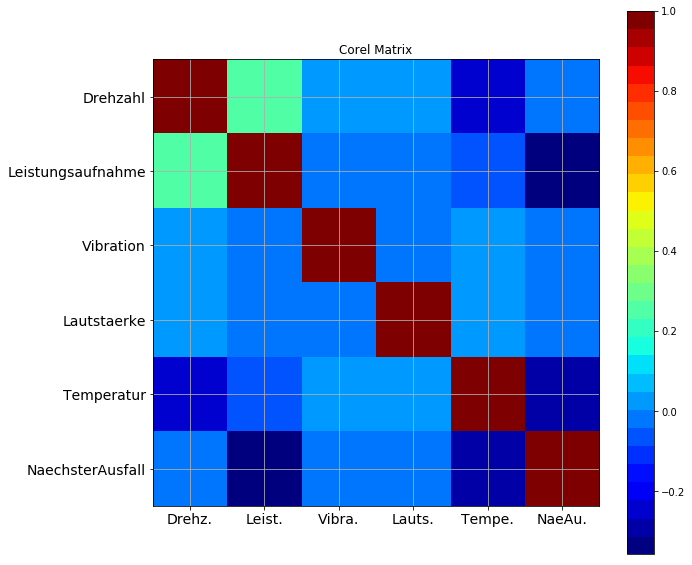

In [47]:
from matplotlib import pyplot as plt
from matplotlib import cm as cm

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
plt.title('Corel Matrix')
labels=['','Drehzahl','Leistungsaufnahme','Vibration','Lautstaerke','Temperatur','NaechsterAusfall']
labels_2=['','Drehz.','Leist.','Vibra.','Lauts.','Tempe.','NaeAu.']
ax1.set_xticklabels(labels_2,fontsize=14)
ax1.set_yticklabels(labels,fontsize=14)
cmap = cm.get_cmap('jet', 30)
cax = ax1.imshow(df_c.corr(), interpolation="nearest", cmap=cmap)
ax1.grid(True)
# Add colorbar, make sure to specify tick locations to match desired ticklabels
fig.colorbar(cax)
plt.show()

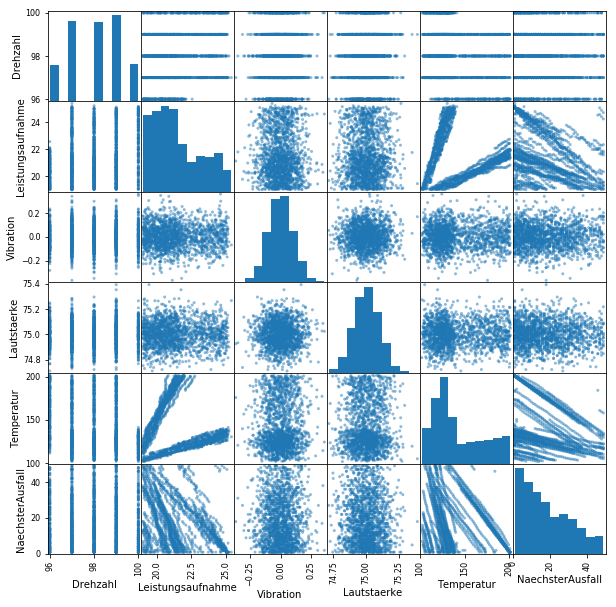

In [48]:
# Scattermatrix zeichnen
pd.plotting.scatter_matrix(df_c.loc[:,'Drehzahl':'NaechsterAusfall'], figsize = (10,10))
plt.show()